In [1]:
from pathlib import Path
from IPython.display import display
import warnings
import contextlib
import io
import sys
from matplotlib.pylab import plt
from tqdm import tqdm

import pandas as pd
import numpy as np

from eegdash.dataset import EEGChallengeDataset
from braindecode.datasets.base import BaseConcatDataset

pd.set_option('display.max_columns', 50)

Input: release_list
Output: 
- train_dataset.pkl
- valid_dataset.pkl
- train_dataset_5sec.pkl

## Step 1 - Prepare full Contrast Change Dataset for every release

Could be very long for first time, for testing you could choose only one release to save your time

If you already downloaded the data from eegdash - simply choose the corresponding cached dir to save your time

In [2]:
# save the source data in root directory
DATA_DIR = Path("../../data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
def prepare_full_dataset(data_dir, release_list):
    all_datasets_list = []
    buf = io.StringIO()

    for release in tqdm(release_list, file=sys.stdout):
        with contextlib.redirect_stderr(buf):
            ds = EEGChallengeDataset(
                release=release,
                task="contrastChangeDetection",
                mini=False,
                description_fields=[
                    "subject","session","run","task",
                    "age","gender","sex","p_factor",
                ],
                cache_dir=data_dir,
            )
        all_datasets_list.append(ds)

    return BaseConcatDataset(all_datasets_list)

In [4]:
release_list = ["R" + str(idx) for idx in range(1, 12)]
print(f"Release list: {release_list}")

dataset_ccd = prepare_full_dataset(data_dir=DATA_DIR, release_list=release_list)
display(dataset_ccd.description)

Release list: ['R1', 'R2', 'R3', 'R4', 'R5', 'R6', 'R7', 'R8', 'R9', 'R10', 'R11']
100%|██████████| 11/11 [00:41<00:00,  3.81s/it]


,subject,run,task,age,sex,p_factor,release_number,ehq_total,commercial_use,full_pheno,attention,internalizing,externalizing,restingstate,despicableme,funwithfractals,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch,gender
0,NDARAC904DMU,1,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
1,NDARAC904DMU,3,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
2,NDARAC904DMU,2,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
3,NDARAG143ARJ,3,contrastChangeDetection,7.6648,M,-0.258,R1,100.05,Yes,Yes,-0.425,1.006,0.509,available,available,available,available,available,available,available,available,available,available,available,unavailable,caution,NaN
4,NDARAG143ARJ,1,contrastChangeDetection,7.6648,M,-0.258,R1,100.05,Yes,Yes,-0.425,1.006,0.509,available,available,available,available,available,available,available,available,available,available,available,unavailable,caution,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5385,NDARZV406UFK,1,contrastChangeDetection,12.0888,M,-0.390,R11,93.34,Yes,Yes,-0.201,1.023,0.228,caution,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN
5386,NDARZV406UFK,2,contrastChangeDetection,12.0888,M,-0.390,R11,93.34,Yes,Yes,-0.201,1.023,0.228,caution,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN
5387,NDARZW623WYG,1,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN
5388,NDARZW623WYG,2,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN


### Task 2 targets visualization

Congratulations!
We already have all required data for Contrast Change Task on run level

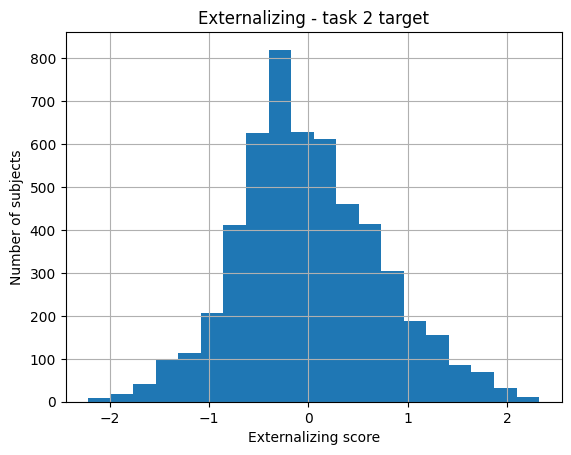

In [5]:
dataset_ccd.description.externalizing.hist(bins=20)
plt.title("Externalizing - task 2 target")
plt.xlabel("Externalizing score")
plt.ylabel("Number of subjects")
plt.show()

In [6]:
n_subjects = dataset_ccd.description.subject.nunique()
print(f"Number of unique subjects in total: {n_subjects}")

Number of unique subjects in total: 1966


### Step 2 — Prepare annotation for window extraction

In this step we prepare the data for training a model that predicts reaction speed.

To do so, we will later cut long run-level EEG recordings into short, stimulus-locked segments.

Here we only prepare the annotations that define where each trial and stimulus occurs, so the recordings can be efficiently split into fixed-length windows in the next step.

1. **`annotate_trials_with_target`**  
   - Finds stimulus/response events and computes the target `rt_from_stimulus` (reaction time).  
2. **`add_aux_anchors`**  
   - Adds helper anchor events used to align future windows.


In [7]:
from braindecode.preprocessing import preprocess, Preprocessor, create_windows_from_events
from eegdash.hbn.windows import (
    annotate_trials_with_target,
    add_aux_anchors,
    add_extras_columns,
    keep_only_recordings_with,
)

warnings.filterwarnings(
    "ignore", message="Omitted .* annotation.*outside data range", category=RuntimeWarning
)

EPOCH_LEN_S = 2.0
SFREQ = 100

transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field="rt_from_stimulus", epoch_length=EPOCH_LEN_S,
        require_stimulus=True, require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs=1)

### Annotations on current step looks like this:

In [8]:
raw = dataset_ccd.datasets[0].raw
ann = raw.annotations.to_data_frame()
ann

,onset,duration,description,anchor,correct,response_onset,response_type,rt_from_stimulus,rt_from_trialstart,stimulus_onset,target
0,2025-08-19 11:53:39.484,2.0,contrast_trial_start,NaN,1,44.414,right_buttonPress,2.13,4.93,42.284,2.13
1,2025-08-19 11:53:42.284,0.0,stimulus_anchor,stimulus,1,44.414,right_buttonPress,2.13,4.93,42.284,2.13
2,2025-08-19 11:53:44.414,0.0,response_anchor,response,1,44.414,right_buttonPress,2.13,4.93,42.284,2.13
3,2025-08-19 11:53:44.684,2.0,contrast_trial_start,NaN,1,49.444,right_buttonPress,1.96,4.76,47.484,1.96
4,2025-08-19 11:53:47.484,0.0,stimulus_anchor,stimulus,1,49.444,right_buttonPress,1.96,4.76,47.484,1.96
...,...,...,...,...,...,...,...,...,...,...,...
61,2025-08-19 11:56:11.888,0.0,stimulus_anchor,stimulus,1,193.578,right_buttonPress,1.69,4.49,191.888,1.69
62,2025-08-19 11:56:13.578,0.0,response_anchor,response,1,193.578,right_buttonPress,1.69,4.49,191.888,1.69
63,2025-08-19 11:56:14.288,2.0,contrast_trial_start,NaN,1,201.508,right_buttonPress,1.22,7.22,200.288,1.22
64,2025-08-19 11:56:20.288,0.0,stimulus_anchor,stimulus,1,201.508,right_buttonPress,1.22,7.22,200.288,1.22


## Step 3 — Select recordings with valid stimulus anchors

We now define the parameters for window extraction:
- ANCHOR = "stimulus_anchor" (the event to align windows to),
- SHIFT_AFTER_STIM = 0.5 s (window start delay after the stimulus),
- and WINDOW_LEN = 2.0 s (window duration).

In [9]:
ANCHOR = "stimulus_anchor"

SHIFT_AFTER_STIM = 0.5
WINDOW_LEN       = 2.0

# Keep only recordings that actually contain stimulus anchors
dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)

raw = dataset.datasets[0].raw
ann = raw.annotations.to_data_frame()
ann

,onset,duration,description,anchor,correct,response_onset,response_type,rt_from_stimulus,rt_from_trialstart,stimulus_onset,target
0,2025-08-19 11:53:39.484,2.0,contrast_trial_start,NaN,1,44.414,right_buttonPress,2.13,4.93,42.284,2.13
1,2025-08-19 11:53:42.284,0.0,stimulus_anchor,stimulus,1,44.414,right_buttonPress,2.13,4.93,42.284,2.13
2,2025-08-19 11:53:44.414,0.0,response_anchor,response,1,44.414,right_buttonPress,2.13,4.93,42.284,2.13
3,2025-08-19 11:53:44.684,2.0,contrast_trial_start,NaN,1,49.444,right_buttonPress,1.96,4.76,47.484,1.96
4,2025-08-19 11:53:47.484,0.0,stimulus_anchor,stimulus,1,49.444,right_buttonPress,1.96,4.76,47.484,1.96
...,...,...,...,...,...,...,...,...,...,...,...
61,2025-08-19 11:56:11.888,0.0,stimulus_anchor,stimulus,1,193.578,right_buttonPress,1.69,4.49,191.888,1.69
62,2025-08-19 11:56:13.578,0.0,response_anchor,response,1,193.578,right_buttonPress,1.69,4.49,191.888,1.69
63,2025-08-19 11:56:14.288,2.0,contrast_trial_start,NaN,1,201.508,right_buttonPress,1.22,7.22,200.288,1.22
64,2025-08-19 11:56:20.288,0.0,stimulus_anchor,stimulus,1,201.508,right_buttonPress,1.22,7.22,200.288,1.22


## Step 4 — Remove late stimulus anchors

Before window extraction, we drop stimulus anchors that occur too close to the end of a recording:
    - when a full 2 s window would not fit.
    
This step filters out those late events and reports how many anchors were removed per run, keeping only recordings with valid stimulus_anchor annotations.

In [10]:
def remove_late_anchors(dataset, anchor='stimulus_anchor', shift=SHIFT_AFTER_STIM, winlen=WINDOW_LEN):
    log = []
    for i, bd in enumerate(dataset.datasets):
        raw = bd.raw
        ann = raw.annotations
        T = float(raw.times[-1])

        desc  = np.asarray(ann.description, dtype=str)
        onset = np.asarray(ann.onset, dtype=float)

        is_anchor = (desc == anchor)
        n_before = int(is_anchor.sum())
        too_late = is_anchor & ((onset + shift + winlen) > T + 1e-9)
        n_removed = int(too_late.sum())
        if n_removed > 0:
            log.append({
                "idx": i,
                "subject": bd.description.get("subject", "NA"),
                "run": bd.description.get("run", "NA"),
                "release": bd.description.get("release_number", "NA"),
                "n_anchors_before": n_before,
                "n_removed": n_removed,
                "max_onset_removed": float(onset[too_late].max()),
                "rec_len_s": T
            })
        keep = ~too_late
        idx = np.where(keep)[0]
        raw.set_annotations(ann[idx], verbose=False)
    if len(log) > 0:
        df_log = pd.DataFrame(log).sort_values(["n_removed","n_anchors_before"], ascending=False)
        print(f"Removed stimuls in total: {int(df_log['n_removed'].sum()) if len(df_log)>0 else 0}")
        print(f"Records removed: {len(df_log)}")
        display(df_log.head(20))
    dataset = keep_only_recordings_with(ANCHOR, dataset)
    return dataset

In [11]:
dataset = remove_late_anchors(dataset, ANCHOR, SHIFT_AFTER_STIM, WINDOW_LEN)
dataset

Removed stimuls in total: 2
Records removed: 2


,idx,subject,run,release,n_anchors_before,n_removed,max_onset_removed,rec_len_s
0,707,NDARGF367KVL,2,R3,35,1,518.846,519.99
1,717,NDARGT682ZWN,2,R3,6,1,74.064,75.99


## Step 5 — Final window extraction and metadata injection

Now we cut each recording into 2-second stimulus-locked windows (starting 0.5 s after stimulus onset) and attach trial metadata such as reaction time, correctness, and response type.
The result single_windows is the complete training dataset of EEG segments aligned to stimuli, ready for model input.

In [12]:
import contextlib
import io

buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    single_windows = create_windows_from_events(
        dataset,
        mapping={ANCHOR: 0},
        trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),                 # +0.5 s
        trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),   # +2.5 s
        window_size_samples=int(EPOCH_LEN_S * SFREQ),
        window_stride_samples=SFREQ,
        preload=True,
    )

# Injecting metadata into the extra mne annotation.
single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc=ANCHOR,
    keys=("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
          )

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,rt_from_stimulus,rt_from_trialstart,stimulus_onset,response_onset,correct,response_type,subject,run,task,age,sex,p_factor,release_number,ehq_total,commercial_use,full_pheno,attention,internalizing,externalizing,restingstate,despicableme,funwithfractals,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch,gender
0,0,4278,4478,2.13,2.13,4.93,42.284,44.414,1,right_buttonPress,NDARAC904DMU,1,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
1,0,4798,4998,1.96,1.96,4.76,47.484,49.444,1,right_buttonPress,NDARAC904DMU,1,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
2,0,5478,5678,2.02,2.02,6.42,54.284,56.304,1,right_buttonPress,NDARAC904DMU,1,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
3,0,6318,6518,1.72,1.72,7.72,62.684,64.404,1,right_buttonPress,NDARAC904DMU,1,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
4,0,6838,7038,1.8,1.8,4.6,67.884,69.684,1,left_buttonPress,NDARAC904DMU,1,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,0,17413,17613,1.72,1.72,6.12,173.628,175.348,1,left_buttonPress,NDARZW623WYG,3,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN
20,0,17933,18133,1.512,1.512,4.312,178.828,180.34,1,right_buttonPress,NDARZW623WYG,3,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN
21,0,18773,18973,1.16,1.16,7.16,187.228,188.388,1,right_buttonPress,NDARZW623WYG,3,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN
22,0,19613,19813,1.04,1.04,7.04,195.628,196.668,1,right_buttonPress,NDARZW623WYG,3,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN


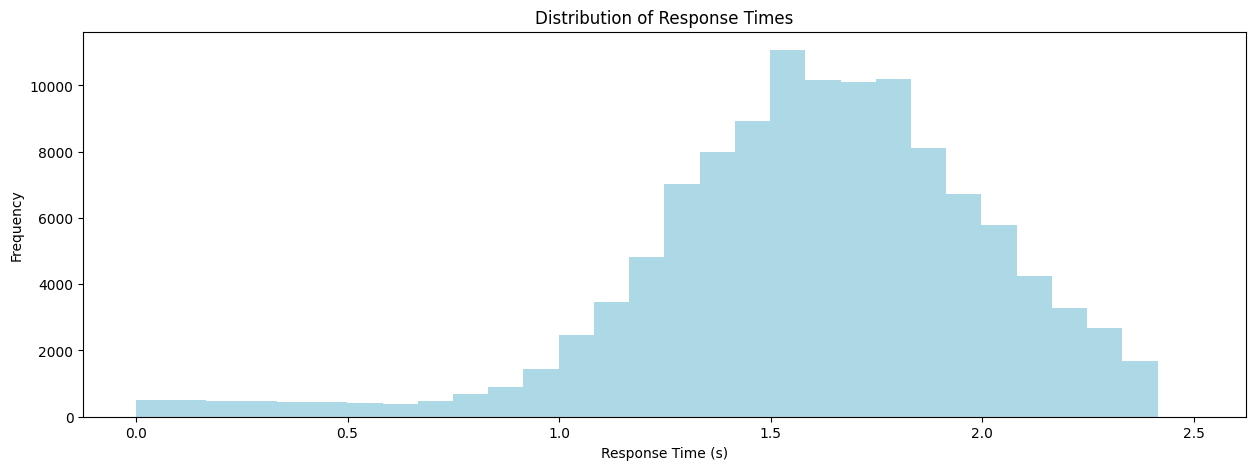

In [13]:
meta_information = single_windows.get_metadata()
display(meta_information)

fig, ax = plt.subplots(figsize=(15, 5))
ax = meta_information["target"].plot.hist(bins=30, ax=ax, color='lightblue')
ax.set_xlabel("Response Time (s)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Response Times")
plt.show()

# train test split

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state

valid_frac = 0.2
seed = 2025

meta_information = single_windows.description

subjects = meta_information["subject"].unique()

train_subj, valid_subj = train_test_split(
    subjects, test_size=valid_frac, random_state=check_random_state(seed), shuffle=True
)

In [15]:
# and finally using braindecode split function, we can do:
subject_split = single_windows.split("subject")

train_set = []
valid_set = []

for s in subject_split:
    if s in train_subj:
        train_set.append(subject_split[s])
    elif s in valid_subj:
        valid_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
valid_set = BaseConcatDataset(valid_set)

print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_set)}")
print(f"Valid:\t{len(valid_set)}")

Number of examples in each split in the minirelease
Train:	92849
Valid:	23049


In [17]:
import pickle

with open("../../artefacts/data/train_dataset.pkl", "wb") as f:
    pickle.dump(train_set, f)

with open("../../artefacts/data/valid_dataset.pkl", "wb") as f:
    pickle.dump(valid_set, f)

## Prepare larger windows for training

Just repeat steps 4-6 with larger WINDOW_LEN

In [27]:
from copy import deepcopy 

ANCHOR = "stimulus_anchor"

SHIFT_AFTER_STIM = 0.0
WINDOW_LEN       = 5.0   
TRIAL_LEN_S = 5.0        
EPOCH_LEN_S = 5.

dataset_5s = deepcopy(dataset_ccd) 
dataset_5s = keep_only_recordings_with(ANCHOR, dataset_5s)
dataset_5s = remove_late_anchors(dataset_5s, ANCHOR, SHIFT_AFTER_STIM, WINDOW_LEN)

Removed stimuls in total: 6
Records removed: 6


,idx,subject,run,release,n_anchors_before,n_removed,max_onset_removed,rec_len_s
3,1501,NDARRE445RHR,1,R4,25,1,563.160,565.99
1,491,NDARPH844KP2,3,R2,24,1,322.266,324.99
0,151,NDARNR773DL4,3,R1,22,1,752.436,754.99
2,716,NDARGT551AFK,2,R3,18,1,213.388,217.99
5,5117,NDARRY803NR6,3,R11,13,1,741.052,744.99
4,4948,NDARLD243KRE,1,R11,8,1,88.688,91.99


In [28]:
import contextlib
import io

buf = io.StringIO()
with contextlib.redirect_stdout(buf):
    single_windows_5s = create_windows_from_events(
        dataset_5s,
        mapping={ANCHOR: 0},
        trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),                 # +0.5 s
        trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),   # +5.5 s
        window_size_samples=int(EPOCH_LEN_S * SFREQ),
        window_stride_samples=SFREQ,
        preload=True,
    )

single_windows_5s = add_extras_columns(
    single_windows_5s,
    dataset_5s,
    desc=ANCHOR,
    keys=("target", "rt_from_stimulus", "rt_from_trialstart",
          "stimulus_onset", "response_onset", "correct", "response_type")
          )

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,rt_from_stimulus,rt_from_trialstart,stimulus_onset,response_onset,correct,response_type,subject,run,task,age,sex,p_factor,release_number,ehq_total,commercial_use,full_pheno,attention,internalizing,externalizing,restingstate,despicableme,funwithfractals,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch,gender
0,0,4228,4728,2.13,2.13,4.93,42.284,44.414,1,right_buttonPress,NDARAC904DMU,1,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
1,0,4748,5248,1.96,1.96,4.76,47.484,49.444,1,right_buttonPress,NDARAC904DMU,1,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
2,0,5428,5928,2.02,2.02,6.42,54.284,56.304,1,right_buttonPress,NDARAC904DMU,1,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
3,0,6268,6768,1.72,1.72,7.72,62.684,64.404,1,right_buttonPress,NDARAC904DMU,1,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
4,0,6788,7288,1.8,1.8,4.6,67.884,69.684,1,left_buttonPress,NDARAC904DMU,1,contrastChangeDetection,11.3386,F,-0.603,R1,71.17,Yes,Yes,-0.446,1.248,0.325,available,available,available,available,available,available,available,available,available,available,unavailable,available,available,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,0,17363,17863,1.72,1.72,6.12,173.628,175.348,1,left_buttonPress,NDARZW623WYG,3,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN
20,0,17883,18383,1.512,1.512,4.312,178.828,180.34,1,right_buttonPress,NDARZW623WYG,3,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN
21,0,18723,19223,1.16,1.16,7.16,187.228,188.388,1,right_buttonPress,NDARZW623WYG,3,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN
22,0,19563,20063,1.04,1.04,7.04,195.628,196.668,1,right_buttonPress,NDARZW623WYG,3,contrastChangeDetection,11.9490,M,0.610,R11,93.34,Yes,Yes,-0.353,0.018,-0.309,unavailable,caution,caution,caution,caution,caution,caution,caution,caution,caution,unavailable,unavailable,caution,NaN


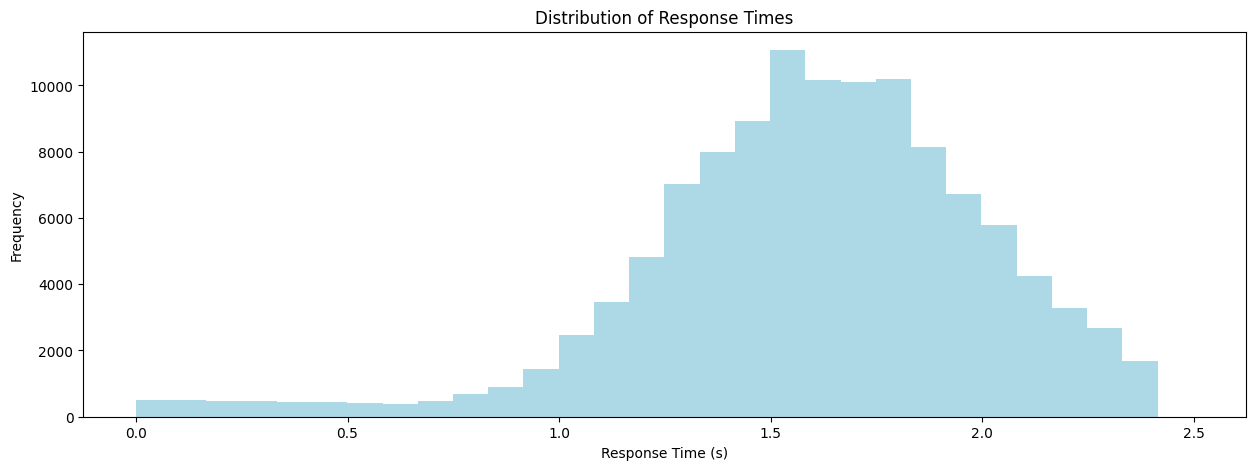

In [29]:
meta_information = single_windows_5s.get_metadata()
display(meta_information)

fig, ax = plt.subplots(figsize=(15, 5))
ax = meta_information["target"].plot.hist(bins=30, ax=ax, color='lightblue')
ax.set_xlabel("Response Time (s)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Response Times")
plt.show()

## Same Train/Valid Split

In [31]:
subject_split = single_windows_5s.split("subject")

train_set = []
valid_set = []

for s in subject_split:
    if s in valid_subj:
        valid_set.append(subject_split[s])
    else:
        train_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
valid_set = BaseConcatDataset(valid_set)

print("Number of examples in each split in the minirelease")
print(f"Train:\t{len(train_set)}")
print(f"Valid:\t{len(valid_set)}")

Number of examples in each split in the minirelease
Train:	92845
Valid:	23047


In [32]:
with open("../../artefacts/data/train_dataset_5sec.pkl", "wb") as f:
    pickle.dump(train_set, f)

with open("../../artefacts/data/valid_dataset_5sec.pkl", "wb") as f:
    pickle.dump(valid_set, f)